### ***Thanks to KSY (By KCH)***

## 데이터 불러오기 및 패키지 설치

In [1]:
import numpy as np
import pandas as pd

import os
import random

import warnings

warnings.filterwarnings(action='ignore')

path = '../../data/' # 환경에 맞게 바꿔주시면 됩니다.

train_df = pd.read_csv(path + 'train_data.csv')
test_df = pd.read_csv(path + 'test_data.csv')

SEED = 42

In [2]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2266586 entries, 0 to 2266585
Data columns (total 6 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   userID            int64 
 1   assessmentItemID  object
 2   testId            object
 3   answerCode        int64 
 4   Timestamp         object
 5   KnowledgeTag      int64 
dtypes: int64(3), object(3)
memory usage: 103.8+ MB


# 유저-Test별로 시퀀스를 분할할 수 있을까?

In [5]:
train_df.groupby('userID')['assessmentItemID'].count().value_counts()

18      47
17      44
24      40
20      39
16      38
        ..
1304     1
896      1
934      1
971      1
9        1
Name: assessmentItemID, Length: 1176, dtype: int64

<AxesSubplot: >

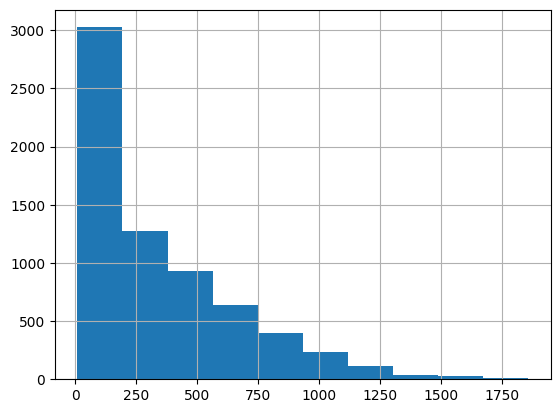

In [23]:
train_df.groupby('userID')['assessmentItemID'].count().hist()

In [6]:
train_df.groupby(['userID' ,'testId'])['assessmentItemID'].count().value_counts()

5     154004
6      69198
7      56625
8      46891
4      12277
9      12164
10      4771
12      3638
3       1580
16      1117
14      1116
11       828
13       259
2        259
18       231
24        92
20        43
21        31
22        20
15        13
26         5
27         2
Name: assessmentItemID, dtype: int64

<AxesSubplot: >

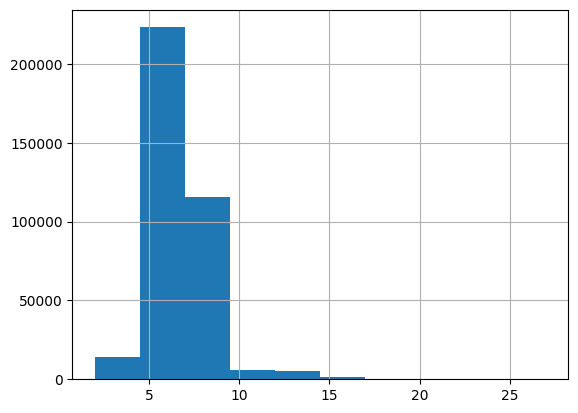

In [24]:
train_df.groupby(['userID' ,'testId'])['assessmentItemID'].count().hist()

현재 유저 시퀀스 데이터로 학습 시 max_len이 20 이하일 때, 성능이 더 좋으므로 max_len이 커봤자 제대로 활용하지 못한다 

=> 시퀀스 길이 분포가 2~27인 유저-테스트 시퀀스 데이터가 더 적합할 수도 있음

In [8]:
train_df.sort_values(by=["userID", "testId", "Timestamp"], axis=0)

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
584,0,A020172001,A020000172,1,2020-10-11 11:06:47,8132
585,0,A020172002,A020000172,1,2020-10-11 11:06:56,8132
586,0,A020172003,A020000172,1,2020-10-11 11:07:13,8132
587,0,A020172004,A020000172,1,2020-10-11 11:07:46,8132
588,0,A020172005,A020000172,0,2020-10-11 11:08:20,8132
...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836


In [25]:
columns = ["userID", "assessmentItemID", "testId", "answerCode", "KnowledgeTag"]
group1 = (  # 각 유저별 [[testId], [assessmentItemID], [KnowledgeTag], [answerCode]]
    train_df[columns]
    .groupby("userID")
    .apply(
        lambda r: (
            r["testId"].values,
            r["assessmentItemID"].values,
            r["KnowledgeTag"].values,
            r["answerCode"].values,
        )
    )
)
group2 = (  # 각 유저-테스트별 [[testId], [assessmentItemID], [KnowledgeTag], [answerCode]]
    train_df[columns]
    .groupby(["userID", "testId"])
    .apply(
        lambda r: (
            #r["userID"].values,
            r["testId"].values,
            r["assessmentItemID"].values,
            r["KnowledgeTag"].values,
            r["answerCode"].values,
        )
    )
)

In [61]:
print(group1.values.shape, group2.values.shape)

(6698,) (365164,)


In [54]:
len(group1.values[0])

4

In [55]:
group1.values[0]

(array(['A060000001', 'A060000001', 'A060000001', 'A060000001',
        'A060000001', 'A060000001', 'A060000003', 'A060000003',
        'A060000003', 'A060000003', 'A060000003', 'A060000003',
        'A060000003', 'A060000005', 'A060000005', 'A060000005',
        'A060000005', 'A060000005', 'A060000005', 'A060000005',
        'A060000007', 'A060000007', 'A060000007', 'A060000007',
        'A060000007', 'A060000007', 'A060000007', 'A080000002',
        'A080000002', 'A080000002', 'A080000002', 'A080000002',
        'A080000002', 'A060000009', 'A060000009', 'A060000009',
        'A060000009', 'A060000009', 'A060000009', 'A060000009',
        'A060000016', 'A060000016', 'A060000016', 'A060000016',
        'A060000016', 'A060000016', 'A060000016', 'A080000004',
        'A080000004', 'A080000004', 'A080000004', 'A080000004',
        'A080000004', 'A080000004', 'A080000004', 'A080000006',
        'A080000006', 'A080000006', 'A080000006', 'A080000006',
        'A080000006', 'A080000006', 'A08

In [62]:
len(group2.values[0])

4

In [63]:
group2.values[0]

(array(['A020000172', 'A020000172', 'A020000172', 'A020000172',
        'A020000172', 'A020000172'], dtype=object),
 array(['A020172001', 'A020172002', 'A020172003', 'A020172004',
        'A020172005', 'A020172006'], dtype=object),
 array([8132, 8132, 8132, 8132, 8132, 8132]),
 array([1, 1, 1, 1, 0, 0]))

In [118]:
test_df.groupby('userID')['assessmentItemID'].count().value_counts()

66     7
52     7
22     7
31     7
15     7
      ..
720    1
580    1
868    1
790    1
28     1
Name: assessmentItemID, Length: 480, dtype: int64

<AxesSubplot: >

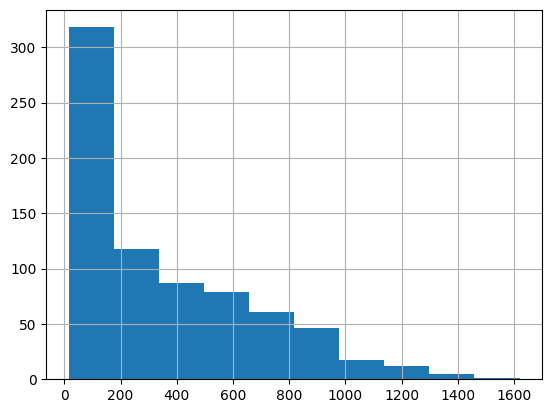

In [119]:
test_df.groupby('userID')['assessmentItemID'].count().hist()

In [120]:
test_df.groupby(['userID' ,'testId'])['assessmentItemID'].count().value_counts()

5     17613
6      7838
7      6934
8      5303
9      1476
4      1403
10      509
12      392
3       196
14      108
16       82
11       80
13       31
2        29
18       19
24        8
20        3
22        1
Name: assessmentItemID, dtype: int64

<AxesSubplot: >

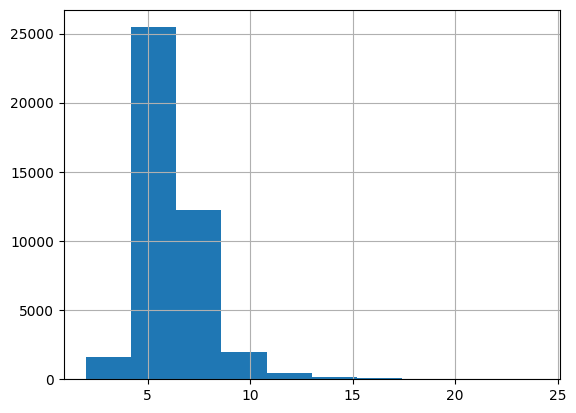

In [121]:
test_df.groupby(['userID' ,'testId'])['assessmentItemID'].count().hist()

In [105]:
group3 = (  # 각 유저-테스트별 [[[testId], assessmentItemID], [KnowledgeTag], [answerCode]]
    test_df[columns]
    .groupby(["userID", "testId"])
    .apply(
        lambda r: (
            #r["userID"].values,
            r["testId"].values,
            r["assessmentItemID"].values,
            r["KnowledgeTag"].values,
            r["answerCode"].values,
        )
    )
)

In [107]:
group3.values.shape

(42025,)

In [109]:
len(group3.values[0])

4

In [110]:
group3.values[0]

(array(['A020000001', 'A020000001', 'A020000001', 'A020000001',
        'A020000001'], dtype=object),
 array(['A020001001', 'A020001002', 'A020001003', 'A020001004',
        'A020001005'], dtype=object),
 array([7916, 7916, 7916, 7916, 7916]),
 array([1, 1, 1, 1, 0]))

In [117]:
-1 in group3.values[0][3]

False

In [136]:
tmp = []
for i in range(len(group3.values)):
    if -1 in group3.values[i][3]:
        tmp.append(group3.values[i])

In [137]:
len(tmp)

744

In [138]:
tmp[0]

(array(['A050000133', 'A050000133', 'A050000133', 'A050000133',
        'A050000133', 'A050000133', 'A050000133', 'A050000133'],
       dtype=object),
 array(['A050133001', 'A050133002', 'A050133003', 'A050133004',
        'A050133005', 'A050133006', 'A050133007', 'A050133008'],
       dtype=object),
 array([5288, 5288, 5289, 5289, 5288, 5288, 5289, 5289]),
 array([ 1,  1,  1,  1,  1,  1,  0, -1]))

## valid split

테스트 셋과 동일한 조건으로 나누자

유저 기준으로 10~20% 정도 비율의 userID를 정해서 마지막 시퀀스를 valid로 처리

In [29]:
# 현재 코드 기준으로는 userid를 알 수 없어서 불가능...
group2.values.shape

(365164,)

In [4]:
columns = ["userID", "assessmentItemID", "testId", "answerCode", "KnowledgeTag"]

df = pd.concat([train_df, test_df])
df = df.sort_values(by=["userID", "testId", "Timestamp"], axis=0)
group5 = (  # 각 유저-테스트별 [[[testId], assessmentItemID], [KnowledgeTag], [answerCode]]
    df[columns]
    .groupby(["userID", "testId"])
    .apply(
        lambda r: (
            #r["userID"].values,
            r["testId"].values,
            r["assessmentItemID"].values,
            r["KnowledgeTag"].values,
            r["answerCode"].values,
        )
    )
)

In [27]:
df.groupby(["userID", "testId"]).value_counts()

userID  testId      assessmentItemID  answerCode  Timestamp            KnowledgeTag
0       A020000172  A020172001        1           2020-10-11 11:06:47  8132            1
                    A020172002        1           2020-10-11 11:06:56  8132            1
                    A020172003        1           2020-10-11 11:07:13  8132            1
                    A020172004        1           2020-10-11 11:07:46  8132            1
                    A020172005        0           2020-10-11 11:08:20  8132            1
                                                                                      ..
7441    A030000071  A030071005        0           2020-06-05 06:50:21  438             1
        A040000165  A040165001        1           2020-08-21 01:06:39  8836            1
                    A040165002        1           2020-08-21 01:06:50  8836            1
                    A040165003        1           2020-08-21 01:07:36  8836            1
                    A04016

In [ ]:
ui = group5.count('userID').values

In [29]:
ui

array([104, 153,  48, ...,   3,   3,   2])

In [24]:
group5.values[ui[0]+ui[1]]

(array(['A030000001', 'A030000001', 'A030000001', 'A030000001',
        'A030000001'], dtype=object),
 array(['A030001001', 'A030001002', 'A030001003', 'A030001004',
        'A030001005'], dtype=object),
 array([307, 307, 307, 307, 307]),
 array([1, 1, 1, 1, 1]))

## test data 활용

In [24]:
print(train_df.shape, test_df.shape, len(train_df)+len(test_df))

(2266586, 6) (260114, 6) 2526700


In [83]:
total_df = pd.concat([train_df, test_df])

In [84]:
group4 = (  # 각 유저-테스트별 [[[testId], assessmentItemID], [KnowledgeTag], [answerCode]]
    total_df[columns]
    .groupby(["userID", "testId"])
    .apply(
        lambda r: (
            #r["userID"].values,
            r["testId"].values,
            r["assessmentItemID"].values,
            r["KnowledgeTag"].values,
            r["answerCode"].values,
        )
    )
)

In [88]:
group4

userID  testId    
0       A020000172    ([A020000172, A020000172, A020000172, A0200001...
        A020000174    ([A020000174, A020000174, A020000174, A0200001...
        A020000181    ([A020000181, A020000181, A020000181, A0200001...
        A020000182    ([A020000182, A020000182, A020000182, A0200001...
        A020000183    ([A020000183, A020000183, A020000183, A0200001...
                                            ...                        
7440    A030000136    ([A030000136, A030000136, A030000136, A0300001...
        A030000197    ([A030000197, A030000197, A030000197, A0300001...
        A050000096    ([A050000096, A050000096, A050000096, A0500000...
7441    A030000071    ([A030000071, A030000071, A030000071, A0300000...
        A040000165    ([A040000165, A040000165, A040000165, A0400001...
Length: 407189, dtype: object

In [109]:
group4.values[0]

(array(['A020000172', 'A020000172', 'A020000172', 'A020000172',
        'A020000172', 'A020000172'], dtype=object),
 array(['A020172001', 'A020172002', 'A020172003', 'A020172004',
        'A020172005', 'A020172006'], dtype=object),
 array([8132, 8132, 8132, 8132, 8132, 8132]),
 array([1, 1, 1, 1, 0, 0]))

# asset 파일도 수정해야 할까?

In [ ]:
from sklearn.preprocessing import LabelEncoder

cate_cols = ["assessmentItemID", "testId", "KnowledgeTag"]
is_train = True

for col in cate_cols:

    le = LabelEncoder()
    if is_train:
        # For UNKNOWN class
        a = df[col].unique().tolist() + ["unknown"]
        le.fit(a)
        self.__save_labels(le, col)
    else:
        label_path = os.path.join(self.args.asset_dir, col + "_classes.npy")
        le.classes_ = np.load(label_path)

        df[col] = df[col].apply(
            lambda x: x if str(x) in le.classes_ else "unknown"
        )

    # 모든 컬럼이 범주형이라고 가정
    df[col] = df[col].astype(str)
    test = le.transform(df[col])
    df[col] = test

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2266586 entries, 0 to 2266585
Data columns (total 6 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   userID            int64 
 1   assessmentItemID  object
 2   testId            object
 3   answerCode        int64 
 4   Timestamp         object
 5   KnowledgeTag      int64 
dtypes: int64(3), object(3)
memory usage: 103.8+ MB


In [10]:
print('userID:', len(set(train_df['userID'].values)), len(set(test_df['userID'].values)))   # userID는 겹치지 않아서 변수로 넣어주려면 npy를 따로 만들던가 실수로 넣어주기 -> KnowledgeTag는 int형인데 인코딩해서 카테고리컬로 넣어줌..
print('assessmentItemID:', len(set(train_df['assessmentItemID'].values)), len(set(test_df['assessmentItemID'].values)))
print('testId:', len(set(train_df['testId'].values)), len(set(test_df['testId'].values)))
print('KnowledgeTag:', len(set(train_df['KnowledgeTag'].values)), len(set(test_df['KnowledgeTag'].values)))
print('Timestamp:', len(set(train_df['Timestamp'].values)), len(set(test_df['Timestamp'].values)))
# npy파일을 따로 만들 필요는 없겠다. timestamp는 인코딩 안하고 numeric 값으로 넣을까? => 아니면 주요한 피쳐만(month, hour + day) 뽑아서 카테고리컬 인코딩?

userID: 6698 744
assessmentItemID: 9454 9454
testId: 1537 1537
KnowledgeTag: 912 912
Timestamp: 2076774 256622


# 시퀀스에 피쳐 추가

## Timestamp

In [47]:
import time
from datetime import datetime

In [50]:
datetime(2020,2,16,15,15)

datetime.datetime(2020, 2, 16, 15, 15)

In [51]:
datetime(2020,2,16,15,15).timestamp()

1581866100.0

In [30]:
def convert_time(s):
    timestamp = time.mktime(
        datetime.strptime(s, "%Y-%m-%d %H:%M:%S").timetuple()
    )
    return int(timestamp)

train_df["Timestamp"] = train_df["Timestamp"].apply(convert_time)

In [42]:
time.mktime(
        datetime.strptime('2020-03-24 00:17:11', "%Y-%m-%d %H:%M:%S").timetuple()
    )

1585009031.0

In [32]:
train_df["Timestamp"]

0          1585009031
1          1585009034
2          1585009042
3          1585009049
4          1585009056
              ...    
2266581    1591339821
2266582    1597971999
2266583    1597972010
2266584    1597972056
2266585    1597972129
Name: Timestamp, Length: 2266586, dtype: int64

In [44]:
len(set(train_df["Timestamp"].values))

2076774

# Right Padding

In [54]:
import torch

def collate(batch):
    col_n = len(batch[0])
    col_list = [[] for _ in range(col_n)]
    max_seq_len = len(batch[0][-1])

    # batch의 값들을 각 column끼리 그룹화
    for row in batch:
        for i, col in enumerate(row):
            pre_padded = torch.zeros(max_seq_len)
            pre_padded[-len(col) :] = col
            col_list[i].append(pre_padded)

    for i, _ in enumerate(col_list):
        col_list[i] = torch.stack(col_list[i])

    return tuple(col_list)

In [67]:
pre_padded = torch.zeros(20)

In [68]:
pre_padded[:3] = 1

In [69]:
pre_padded

tensor([1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.])

In [77]:
tmp = torch.Tensor([[0,1], [1,0]])
interaction_mask = tmp.roll(shifts=1, dims=1)

In [78]:
interaction_mask

tensor([[1., 0.],
        [0., 1.]])

In [81]:
interaction_mask[:, 0] = 3

In [82]:
interaction_mask

tensor([[3., 0.],
        [3., 1.]])

In [114]:
a = torch.Tensor()
torch.cat([a, tmp[0][0]])

RuntimeError: zero-dimensional tensor (at position 1) cannot be concatenated

# userID

In [3]:
print(len(set(train_df['userID'].unique()) - set(test_df['userID'].unique())))
print(len(set(train_df['userID'].unique())))

6698
6698


train과 test 간 같은 유저가 존재하지 않습니다. test는 train에 없는 유저를 추측해야하죠.

이러한 train/test의 특성을 살려 valid 역시 유저를 기준으로 분할합니다.

In [4]:
ratio = 0.8 # test/valid 비율 설정

userids = train_df['userID'].unique()

random.seed(SEED)
random.shuffle(userids)

size = int(len(userids) * ratio)
train_userids = userids[:size]
valid_userids = userids[size:]

train = train_df.loc[train_df['userID'].isin(train_userids)]
valid = train_df.loc[train_df['userID'].isin(valid_userids)]

## 통계량 분석

In [5]:
tem = train_df.groupby('userID')['answerCode']
tem = pd.DataFrame({'mean' : tem.mean(), 'cnt':tem.count()}).reset_index()
tem

,userID,mean,cnt
0,0,0.630872,745
1,1,0.853162,933
2,2,0.612319,276
3,5,0.795918,833
4,6,0.442997,921
...,...,...,...
6693,7436,0.466667,15
6694,7437,0.375000,16
6695,7438,0.750000,16
6696,7440,0.400000,15


<AxesSubplot: >

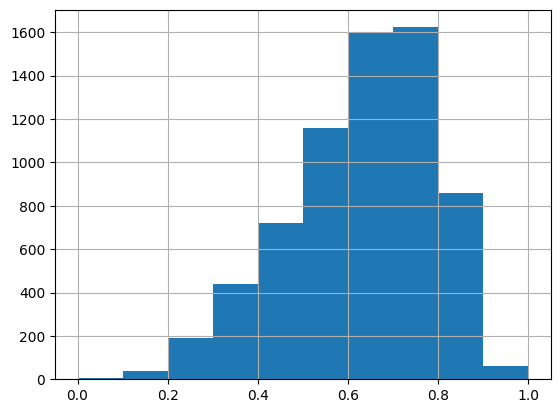

In [6]:
tem['mean'].hist()

유저 별 정답률에 유의미한 차이가 보입니다.

한 명 빼고는 최소 15문제씩 푼 것을 확인할 수 있습니다.

다만 테스트 데이터에는 cold start 유저만 있기 때문에 이 부분을 잘 고려해야겠습니다.

# assessmentItemID & testId

|x|X|B|
|-|-|-|
|range(1,10)|range(10)|[0,1]|

**assessmentItemID 형태**: A + 시험지 번호 6자리 + 시험지 내 문항의 번호 3자리 (A 0x0BXX 0BX)

**testId 형태**: A + 시험지 번호 중 앞 3자리 + 000 + 시험지 번호 중 뒷 3자리 (A 0x0 000 BXX)

***=> testId의 정보는 assessmentItemID에 포함되어 있음***

In [7]:
for i in range(10):
    print(f'{i}번째 value_count')
    print(train_df['assessmentItemID'].str[i].value_counts())
    print()

0번째 value_count
A    2266586
Name: assessmentItemID, dtype: int64

1번째 value_count
0    2266586
Name: assessmentItemID, dtype: int64

2번째 value_count
7    279164
5    275773
3    273762
1    272082
2    268327
4    267323
6    264434
8    246336
9    119385
Name: assessmentItemID, dtype: int64

3번째 value_count
0    2266586
Name: assessmentItemID, dtype: int64

4번째 value_count
0    1335224
1     931362
Name: assessmentItemID, dtype: int64

5번째 value_count
2    274486
1    272347
3    260710
0    257671
5    237026
4    232875
6    206081
7    185973
8    181872
9    157545
Name: assessmentItemID, dtype: int64

6번째 value_count
3    249769
1    247657
7    247545
5    242085
9    234204
4    215019
2    213197
8    209236
6    207763
0    200111
Name: assessmentItemID, dtype: int64

7번째 value_count
0    2266586
Name: assessmentItemID, dtype: int64

8번째 value_count
0    2255139
1      11447
Name: assessmentItemID, dtype: int64

9번째 value_count
1    375107
2    373456
3    371909
4    36970

In [8]:
print(f"assessmentItemID의 차원: {train_df['assessmentItemID'].nunique()}\ntestId의 차원: {train_df['testId'].nunique()}")

assessmentItemID의 차원: 9454
testId의 차원: 1537


assessmentItemID 변수 2번째 값(시험지 변수의 일부)에 대한 정답률을 살펴보면

In [9]:
train_df['test_2'] = train_df['assessmentItemID'].str[2]

tem = train_df.groupby('test_2')['answerCode']

pd.DataFrame({'mean' : tem.mean(), 'cnt':tem.count()}).reset_index()

,test_2,mean,cnt
0,1,0.800876,272082
1,2,0.737593,268327
2,3,0.702238,273762
3,4,0.684056,267323
4,5,0.658208,275773
5,6,0.709232,264434
6,7,0.521876,279164
7,8,0.502598,246336
8,9,0.449948,119385


이 변수에 따라 정답률이 유의미한 차이를 가지므로, 문제 난이도와 관련된 변수라고 생각할 수 있음 (변수가 커질수록 난이도가 높아지는 경향)

시험지 변수의 나머지 부분도 확인해보면

In [10]:
train_df['test_456'] = train_df['assessmentItemID'].str[4:7]
train_df.groupby('test_456')['answerCode'].mean().sort_values()

test_456
057    0.529107
047    0.542518
049    0.550103
051    0.557857
069    0.558188
         ...   
179    0.819098
185    0.831546
195    0.835409
198    0.853838
196    0.895706
Name: answerCode, Length: 198, dtype: float64

시험지의 나머지 부분도 동일하게 유의미한 정답률 차이를 보이고, 변수가 커질수록 난이도가 높아지는 경향을 보임

In [11]:
train_df['problem_id'] = train_df['assessmentItemID'].str[-3:]
tem = train_df.groupby('problem_id')['answerCode']

pd.DataFrame({'mean' : tem.mean(), 'cnt':tem.count()}).reset_index()

,problem_id,mean,cnt
0,001,0.749916,371755
1,002,0.720062,370972
2,003,0.687773,371640
3,004,0.663364,369705
4,005,0.599134,360607
5,006,0.555685,197772
6,007,0.515399,127121
7,008,0.457156,67150
8,009,0.481729,18417
9,010,0.527892,5342


문제 번호에 따른 정답률 차이도 유의미함

번호가 커질수록 풀은 문제의 수는 줄어들고(해당 문항 번호가 없거나, 사용자들이 잘 풀지 않음),
난이도가 높아지는 경향이 있음 

결론적으로 정답률에 유의미한 영향을 주는 변수지만, assessmentID에 모든 정보가 이미 들어있어, 하위 변수로 쪼개는 것이 성능에 긍정적인 영향을 줄지 고려해야함

# answerCode

문제풀이의 정답 여부를 나타내는 데이터

label로 사용하지만, 정제해서 학습데이터로도 활용 가능

ex) 시계열 데이터에서 이전 문제풀이의 정답여부, 현재까지의 누적 정답률 등

# Timestamp

In [13]:
# datetime 자료형으로 변환하면 날짜 변수를 훨씬 쉽게 접근할 수 있습니다.
train_df['Timestamp'] = pd.to_datetime(train_df['Timestamp'])
# train['Timestamp'].dt.year # 연도 정보
# train['Timestamp'].dt.month # 월 정보 -
# train['Timestamp'].dt.weekday # 일 정보
# train['Timestamp'].dt.day # 일 정보
# train['Timestamp'].dt.hour # 시간 정보 -
# train['Timestamp'].dt.minute # 분 정보
# train['Timestamp'].dt.second # 초 정보

In [13]:
train_df['year'] = train_df['Timestamp'].dt.year
train_df['year'].value_counts()

2020    2266567
2019         19
Name: year, dtype: int64

In [14]:
train_df['month'] = train_df['Timestamp'].dt.month
train_df.groupby('month')['answerCode'].mean().sort_values()

month
12    0.496304
11    0.505544
5     0.643317
4     0.649545
6     0.651967
8     0.657599
7     0.665650
9     0.668872
10    0.670372
3     0.682643
2     0.687222
1     0.712199
Name: answerCode, dtype: float64

월별로 정답률에 차이가 있음 

In [15]:
train_df['weekday'] = train_df['Timestamp'].dt.weekday
train_df.groupby('weekday')['answerCode'].mean().sort_values()

weekday
5    0.603206
2    0.641011
4    0.643362
3    0.658466
1    0.667046
6    0.675257
0    0.676518
Name: answerCode, dtype: float64

In [16]:
train_df['day'] = train_df['Timestamp'].dt.day
train_df.groupby('day')['answerCode'].mean().sort_values()

day
5     0.642880
4     0.644408
29    0.645162
28    0.645931
30    0.646526
19    0.646682
11    0.647353
18    0.649955
27    0.650301
17    0.652006
1     0.652507
25    0.652689
23    0.653157
3     0.653433
12    0.654113
22    0.654478
16    0.654808
24    0.655858
2     0.656055
10    0.656140
31    0.656187
9     0.657514
15    0.658230
21    0.659397
26    0.659470
8     0.660020
14    0.660140
20    0.660884
7     0.661618
13    0.662228
6     0.666662
Name: answerCode, dtype: float64

In [17]:
train_df['hour'] = train_df['Timestamp'].dt.hour
train_df.groupby('hour')['answerCode'].mean().sort_values()

hour
19    0.528847
20    0.532575
18    0.547598
17    0.553639
16    0.576721
21    0.588505
5     0.624776
6     0.629941
3     0.632685
4     0.633292
2     0.642410
7     0.643050
1     0.644321
22    0.644492
0     0.649446
23    0.659023
8     0.667948
15    0.672702
9     0.682764
14    0.695666
10    0.699632
13    0.704881
11    0.709786
12    0.715727
Name: answerCode, dtype: float64

시간별로 정답률에 차이가 있음 

In [18]:
train_df['minute'] = train_df['Timestamp'].dt.minute
train_df.groupby('minute')['answerCode'].mean().sort_values()

minute
53    0.644429
7     0.646893
55    0.647596
37    0.649202
2     0.649677
16    0.650084
48    0.650175
45    0.650834
50    0.650882
3     0.651078
0     0.651202
35    0.651310
57    0.651446
32    0.651460
56    0.652514
27    0.652577
24    0.652623
10    0.652976
26    0.652998
52    0.653139
21    0.653222
39    0.653366
44    0.653533
58    0.653534
28    0.653840
19    0.653980
13    0.654409
36    0.654502
5     0.654629
34    0.654658
47    0.654912
14    0.655023
11    0.655082
15    0.655097
30    0.655330
23    0.655493
17    0.655561
51    0.655938
20    0.656082
40    0.656216
41    0.656288
43    0.656564
42    0.656601
18    0.656799
49    0.656924
8     0.656956
4     0.657004
38    0.657189
46    0.657303
33    0.657528
9     0.657695
59    0.657762
31    0.657825
29    0.657931
1     0.658024
25    0.658536
12    0.658804
54    0.659395
6     0.659787
22    0.660802
Name: answerCode, dtype: float64

In [19]:
train_df['second'] = train_df['Timestamp'].dt.second
train_df.groupby('second')['answerCode'].mean().sort_values()

second
24    0.650345
20    0.650632
31    0.650672
30    0.651593
25    0.651721
55    0.651847
33    0.652003
46    0.652047
0     0.652159
45    0.652165
48    0.652241
18    0.652274
40    0.652454
47    0.652593
42    0.652749
22    0.653138
28    0.653407
16    0.653423
13    0.653511
3     0.653570
5     0.653597
57    0.653876
35    0.654002
32    0.654034
44    0.654096
19    0.654165
15    0.654257
26    0.654367
9     0.654436
51    0.654512
11    0.654534
21    0.654619
53    0.654731
58    0.654813
27    0.654852
50    0.654987
8     0.655051
7     0.655091
43    0.655142
36    0.655166
49    0.655308
34    0.655323
39    0.655383
52    0.655663
14    0.655668
54    0.655687
41    0.655831
10    0.655837
38    0.655861
12    0.655879
56    0.655956
17    0.656008
23    0.656471
59    0.656660
6     0.656662
4     0.657033
37    0.657369
29    0.657607
1     0.657854
2     0.659939
Name: answerCode, dtype: float64

다음번 문제풀이와의 시간차이를 이용해서 문제풀이에 걸린 시간을 변수로 사용하는 것은 이상치가 많을 뿐더러,
 
마지막 문제풀이의 정답여부를 맞혀야되는 문제에서는 가장 중요한 테스트에서 데이터로 사용 불가능함

=> 그렇다면 이전 문제풀이와의 시간차이를 이용해서 연속적인 문제풀이 과정에 있는것인지 여부를 변수로 활용해보자 (단순화시켜서 이상치도 정리됨)

1: 연속 문제풀이 / 0: 연속 아님

각 유저에 대해 첫 번째 문제풀이는 0으로 고정하고 이후 문제풀이에 대해서 값 계산해보기

In [16]:
threshold = 30*60
train_df['continuous'] = 0
for i in range(1, len(train_df)):
    if train_df['userID'][i] != train_df['userID'][i-1]:
        continue
    else:
        if (train_df['Timestamp'].values[i] - train_df['Timestamp'].values[i-1]) / np.timedelta64(1, 's') < threshold:
            train_df['continuous'][i] = 1


In [17]:
train_df.groupby('continuous')['answerCode'].mean().sort_values()

continuous
1    0.638364
0    0.743915
Name: answerCode, dtype: float64

# KnowledgeTag

In [18]:
train_df.groupby('KnowledgeTag')['answerCode'].mean().sort_values()

KnowledgeTag
8911     0.188940
10332    0.250000
9125     0.257009
10590    0.268139
5763     0.278027
           ...   
1580     0.941896
1582     0.949280
1577     0.950461
7224     0.955022
1878     0.977778
Name: answerCode, Length: 912, dtype: float64

문제 카테고리도 간단하게 살펴봤는데요. 몇 안되는 칼럼인 만큼 상당히 유의미한 정답률 차이를 보여주네요.

In [19]:
train_df['KnowledgeTag'].value_counts()

7597    12892
7600    10734
2010    10176
7621     9709
8127     9006
        ...  
5142       47
2871       46
4978       46
7125       45
2613       44
Name: KnowledgeTag, Length: 912, dtype: int64

카테고리 별 문제가 최소한 40개 이상은 됩니다. 따로 전처리하지 않아도 좋을 것 같아요.

# train/valid 데이터 분할

In [20]:
ratio = 0.8 # test/valid 비율 설정

userids = train_df['userID'].unique()

random.seed(SEED)
random.shuffle(userids)

size = int(len(userids) * ratio)
train_userids = userids[:size]
valid_userids = userids[size:]

train = train_df.loc[train_df['userID'].isin(train_userids)]
valid = train_df.loc[train_df['userID'].isin(valid_userids)]

In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1815471 entries, 0 to 2266585
Data columns (total 13 columns):
 #   Column            Dtype         
---  ------            -----         
 0   userID            int64         
 1   assessmentItemID  object        
 2   testId            object        
 3   answerCode        int64         
 4   Timestamp         datetime64[ns]
 5   KnowledgeTag      int64         
 6   test_2            object        
 7   test_456          object        
 8   problem_id        object        
 9   year              int64         
 10  month             int64         
 11  hour              int64         
 12  continuous        int64         
dtypes: datetime64[ns](1), int64(7), object(5)
memory usage: 193.9+ MB
